In [107]:
import geopandas as gpd

In [108]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors

from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
import conda

import locale
from datetime import datetime
from IPython.display import HTML
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

'en_US.UTF8'

In [109]:
pd.set_option('mode.chained_assignment','raise')
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [110]:
def get_cell_styles(color):
    return 'background-color: %s; font-size: %s; font-weight: %s;' % (color, '1.2em', 'bold')

def get_column_color(column_name):
    if (column_name in ['FULL_PROJECT_NUM', 'CORE_PROJECT_NUM']):
        return get_cell_styles('#ff677d')
    elif (column_name in ['ACTIVITY', 'ADMINISTERING_IC', 'APPLICATION_TYPE', 'SERIAL_NUMBER', 'SUPPORT_YEAR']):
        return get_cell_styles('#30e3ca')
    return ''

def highlight_project_numbers(val):
    return [get_column_color(column_name) for column_name in list(val.index)]

# Project structure

This is a my standard directory structure for local development. 

All original data goes in `data` and is never manipulated. The preprocessing notebook reads the data and does any processing, feature engineering and transformations and saves the output to `out` directory. The `utils` directory should hold any special resable scripts or code.

```bash session
├── Analysis.ipynb                                               # this notebook
├── Preprocess.ipynb                                             # preprocessing notebook
├── data
│   ├── geo                                                      # shapefiles for maps
│   │   └── cb_2019_us_state_500k.shp
│   └── zips                                                     # Zip to lat/long
│       └── us-zip-code-latitude-and-longitude.csv 
├── out
│   ├── csv                                                      # output of preprocessing
│   │   └── post_processed_2020-05-14T15:17:56+00:00.csv.gzip    # sample (Note: this is not the entire dataset, see utils/get_csvs for script to get all files for yourself)
│   ├── json                                                     # any json output goes here
│   └── models                                                   # any saved models go here
└── utils
    ├── get_csvs                                                 # function to get data
    └── reporter_files.txt                                       # list of reporter files to retrieve
```

# What is the National Institutes of Health (NIH)?

### The NIH is the United States' medical research agency. This analysis aims to examine how the NIH funds medical research.

### Import Data

Data preprocessed from `Preprocess.ipynb` and saved in `'./out/csv/post_processed_{ISO_DATE}.csv.gzip'`

In [111]:
df_us_dtypes = {"PI_NAMEs":"string","INDIRECT_COST_AMT":"float64","FY":"int64","CORE_PROJECT_NUM":"object","PHR":"object","ORG_DEPT":"object","FUNDING_ICs":"object","SUPPORT_YEAR":"float64","STUDY_SECTION_NAME":"object","DIRECT_COST_AMT":"float64","ORG_CITY":"object","ORG_DISTRICT":"float64","APPLICATION_TYPE":"float64","PI_IDS":"object","PROJECT_TITLE":"object","ORG_ZIPCODE":"object","ORG_STATE":"object","ORG_NAME":"object","fromfile":"object","ACTIVITY":"object","PROJECT_TERMS":"string","TOTAL_COST":"float64","Longitude":"float64","IC_NAME":"object","ORG_COUNTRY":"object","STUDY_SECTION":"object","NIH_SPENDING_CATS":"object","PROGRAM_OFFICER_NAME":"object","SUBPROJECT_ID":"float64","FUNDING_MECHANISM":"object","ADMINISTERING_IC":"object","TOTAL_COST_SUB_PROJECT":"float64","SERIAL_NUMBER":"float64","SUFFIX":"object","APPLICATION_ID":"int64","FULL_PROJECT_NUM":"object","Latitude":"float64"}

In [112]:
%%time
date_imported = !date -Is
# Important: Providing random sample of 20% of the records from the output of the preprocess notebook.
# For all of the records, re-run the steps in the preprocess notebook and reference the output file here.
# OUT = './out/csv/post_processed_2020-05-14T15:17:56+00:00.csv.gzip' # sample

OUT = './out/csv/post_processed_2020-05-26T19:18:25+00:00.csv.gzip' # full
df_us = pd.read_csv(OUT, parse_dates=["AWARD_NOTICE_DATE","BUDGET_START","BUDGET_END","PROJECT_START","PROJECT_END"], dtype=df_us_dtypes, compression='gzip')
date_imported

CPU times: user 11.3 s, sys: 1.08 s, total: 12.4 s
Wall time: 12.6 s


['2020-05-26T22:26:37+00:00']

In [113]:
sub = partial(re.sub, "[^0-9]", "")
def extract_pid(x):
    """
    Extract the pids which are usually in the format: "12341234; 45674567; 54235423;"
    """
    t = list(map(sub, x.split(';')))
    return list(filter(None, t))

### Compute some summary statistics

In [114]:
# create a boolean filter to get all awards in fiscal year 2019 and later
is_2019 = df_us['FY'] >= 2019

total_awards_2019 = len(df_us.loc[is_2019]) # total award count
total_cost_sum_2019 = df_us.loc[is_2019, 'TOTAL_COST'].sum() # total award sum
direct_cost_sum_2019 = df_us.loc[is_2019 & (pd.isna(df_us['TOTAL_COST'])), 'DIRECT_COST_AMT'].sum() # direct cost sum (where total_cost is 0 or na)
total_orgs_unique_2019 = len(df_us.loc[is_2019, 'ORG_NAME'].unique()) # count of unique org_names

# all unique PI_IDs
_all_pids = df_us.loc[is_2019, 'PI_IDS'].apply(lambda x: extract_pid(x)) 
all_unique_pids = set(_all_pids.iloc[0]).union(*_all_pids)

top_app_type = df_us.loc[is_2019, 'APPLICATION_TYPE'].value_counts(normalize=True).iloc[0] # top application type by count

In [115]:
styles = ""
with open("./styles/styles-nih.css") as f:
    styles = f.read()
    
HTML(f'<style>{styles}</style>')

In [116]:
mpl.rcdefaults()
sns.set(style="whitegrid")

In [117]:
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 24

# What types of grants are there?

# One way to define grants is by their application type:

In [118]:
import io
import urllib, base64

In [119]:
def save_fig_base64_image(fig, bbox_inches='tight'):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches=bbox_inches, dpi=250)
    buf.seek(0)
    string = base64.b64encode(buf.read())
    uri = 'data:image/png;base64,' + urllib.parse.quote(string)
    return '<img src = "%s"/>' % uri

In [120]:
app_types = { 1: 'New', 2: 'Renewal', 3: 'Revision', 4: 'Extension', 5: 'Non-Competing Continuation', 6: 'Change of Organization Status (Successor-In-Interest)', 7: 'Change of Recipient or Training Institution', 8: 'Change of Institute or Division (Type 5 transfer to another NIH IC)', 9: 'Change of Institute or Division (Type 2 transfer to another NIH IC)' }
vals = pd.DataFrame(df_us.APPLICATION_TYPE.value_counts())
vals = vals.apply(lambda x: pd.Series([app_types[np.int(x.name)], x['APPLICATION_TYPE']]), axis=1)
vals.rename(columns={0: "Application Type", 1: "Count"}, inplace=True)

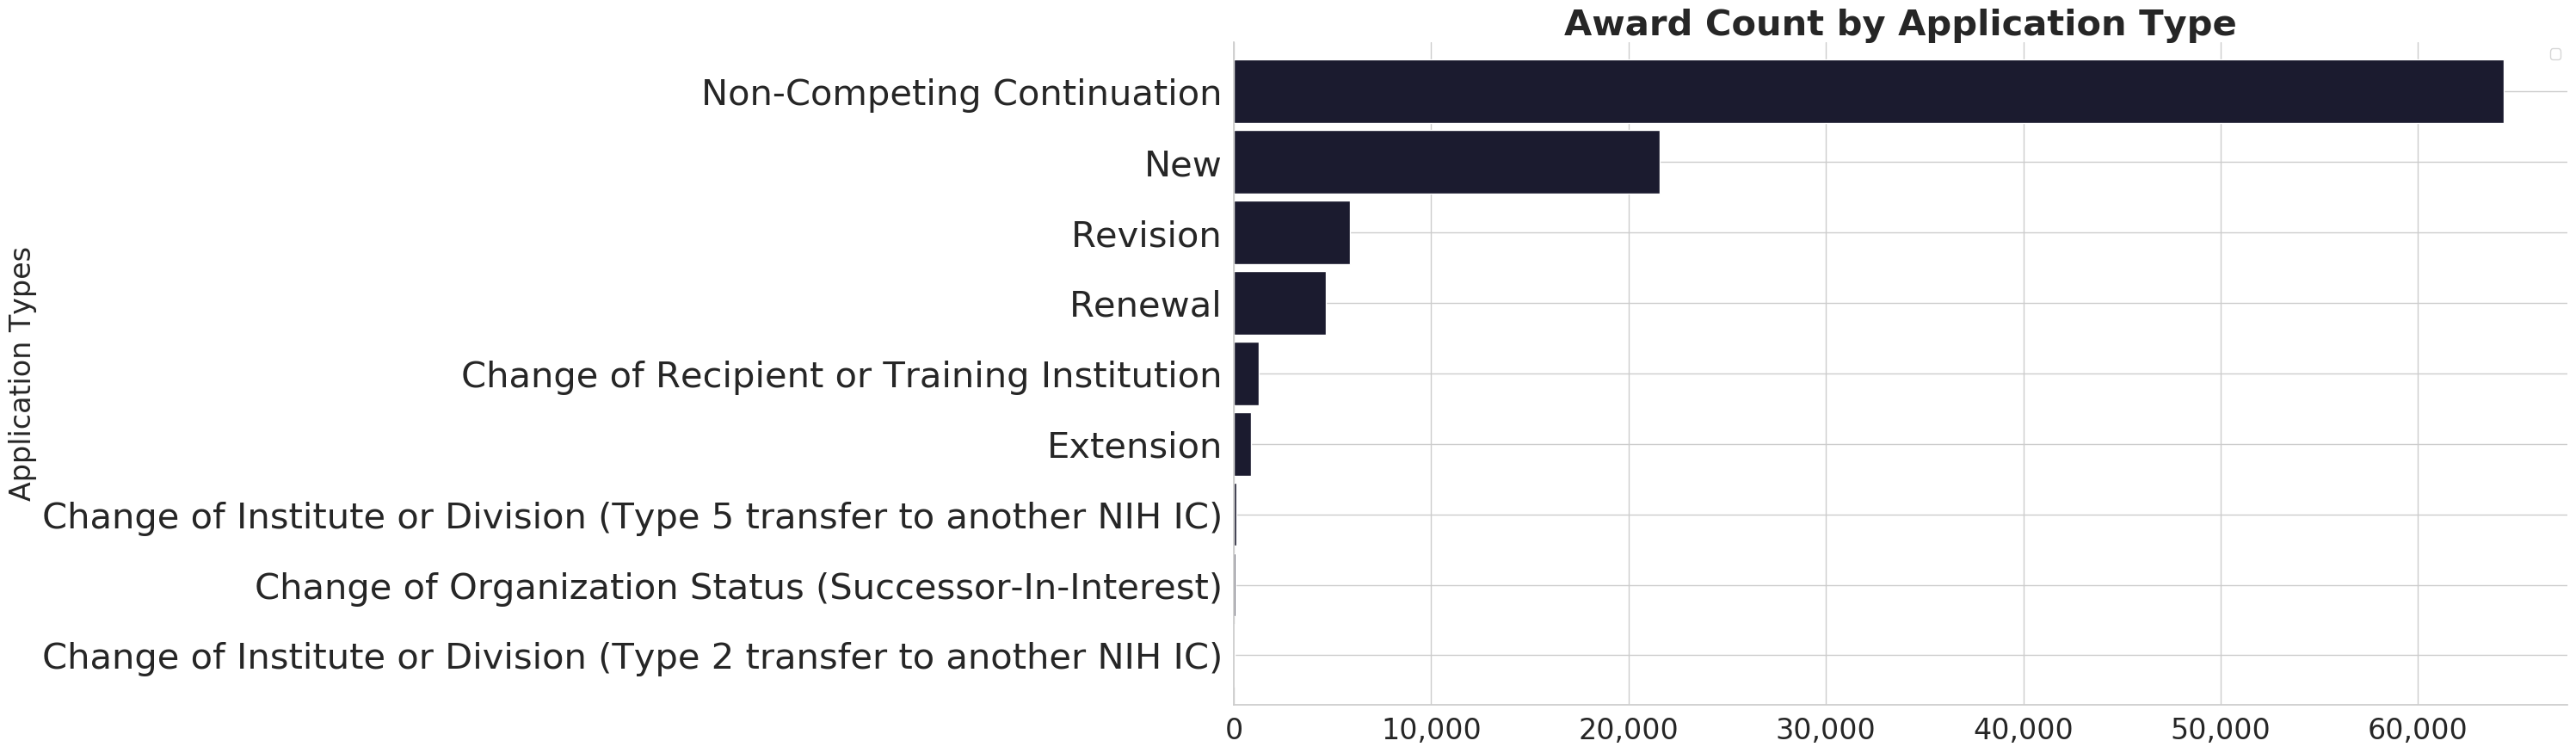

In [121]:
formatter = mtick.StrMethodFormatter('{x:,.0f}')

fig, ax = plt.subplots(figsize=(20, 10))

vals.sort_values('Count').plot(x='Application Type', y='Count', kind='barh', color='#1b1b2f', ax=ax, width=0.9)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Application Types")
ax.set_title("Award Count by Application Type")
ax.legend("")

app_types_chart = save_fig_base64_image(fig)

# For more information about what these application types mean, see [NIH explanation of types of applications](https://grants.nih.gov/grants/how-to-apply-application-guide/prepare-to-apply-and-register/type-of-applications.htm).

  1. New
  2. Renewal
  3. Revision
  4. Extension
  5. **Non-Competing Continuation** - **Request or award for a subsequent budget period within a previously approved project for which a recipient does not have to compete with other applications.**
  6. Change of Organization Status (Successor-In-Interest)
  7. Change of Recipient or Training Institution
  8. Change of Institute or Division (Type 5 transfer to another NIH IC)
  9. Change of Institute or Division (Type 2 transfer to another NIH IC) 

In [122]:
from scipy.stats import norm,  norminvgauss, gumbel_r, gamma, loggamma

In [123]:
stats = df_us.loc[is_2019, ['TOTAL_COST']].describe()
median = stats.loc['50%', 'TOTAL_COST']
awards_over_5M = len(df_us.loc[is_2019 & (df_us['TOTAL_COST'] >= 5e6)])
max_total = locale.currency(stats.loc['max', 'TOTAL_COST'], True, True)
mean_total = locale.currency(stats.loc["mean", "TOTAL_COST"], True, True)
display(HTML(f'<h1>In fiscal year 2019, the median award amount was {locale.currency(median, True, True)}</h1>'))
display(HTML(f'<h3>Award costs are highly skewed to the left. Small awards are most common with <strong>{awards_over_5M}</strong> awards granted <strong>5M</strong> or more.</h3>'))
display(stats)

,TOTAL_COST
count,8.423800e+04
mean,5.098778e+05
std,1.046361e+06
min,1.000000e+00
25%,1.986470e+05
50%,3.697935e+05
75%,5.429260e+05
max,6.605606e+07


In [124]:
_sample = df_us.loc[is_2019]

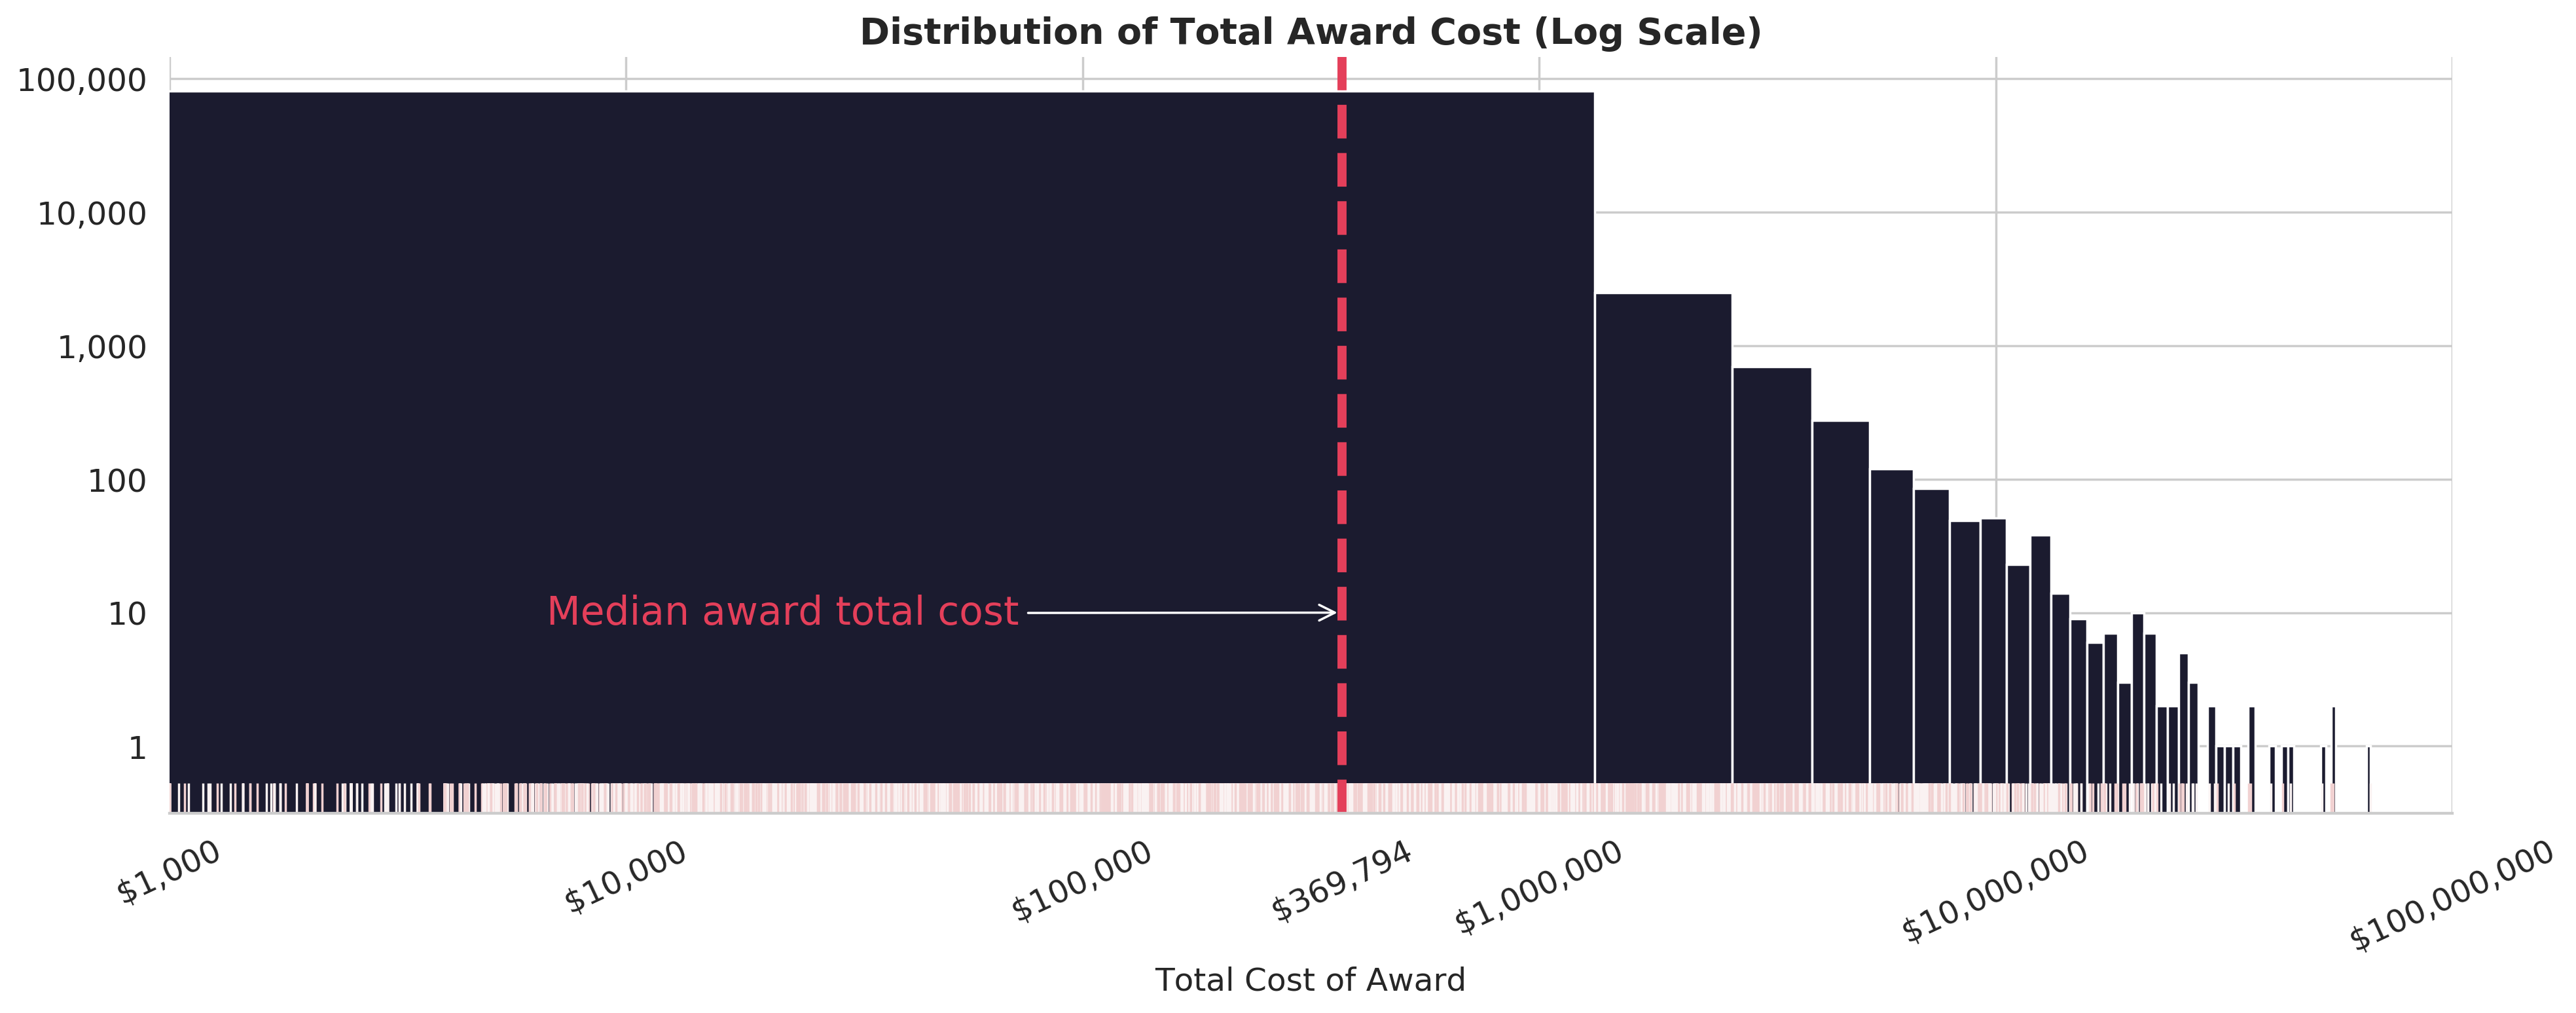

CPU times: user 48.9 s, sys: 543 ms, total: 49.4 s
Wall time: 49.2 s


In [127]:
%%time

xformatter = mtick.StrMethodFormatter('${x:,.0f}')
yformatter = mtick.StrMethodFormatter('{x:,.0f}')

_sample_median = _sample['TOTAL_COST'].median()

fig, ax = plt.subplots(figsize=(18, 6), dpi=250) # specify dpi from save_fig_base64_image otherwise position of annotations can become unstable.

sns.distplot(_sample['TOTAL_COST'], hist=True, hist_kws={ 'log': True, 'alpha': 1 }, kde=False, rug=True, rug_kws={ 'height': 0.04, 'linestyles': 'solid', 'color': [colors.to_rgb('#faf2f2'), colors.to_rgb('#f1d1d1')] }, ax=ax, color='#1b1b2f')

ax.tick_params(axis='x', rotation=25, labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set(xlim=[1000, 100000000], xscale='log', yscale='log')

xticks = list(ax.get_xticks())
xticks.append(_sample_median)
xticks.sort()
ax.set_xticks(xticks)

ax.set_xlim([1000, 100000000])

ax.xaxis.set_major_formatter(xformatter)
ax.yaxis.set_major_formatter(yformatter)

ax.set_title('Distribution of Total Award Cost (Log Scale)', fontdict={ 'fontsize': 16})
ax.set_xlabel('Total Cost of Award', size=14, weight='normal')

ax.annotate('Median award total cost', xy=(_sample_median, 10), textcoords='offset points', xytext=(-350, -5),
            arrowprops={'arrowstyle': '->'}, c='#e43f5a', size='x-large')

ax.axvline(_sample_median, ls='--', color='#e43f5a', lw=4)
plt.show()
# pp.pprint(ax.properties())


distplot = save_fig_base64_image(fig, 'tight')

In [128]:
display(HTML(f'<h1>From fiscal years 2019 and 2020, the NIH has funded:</h1>'))
display(HTML(f'<div class="wrapper"> \
    <div> \
        <h2>{locale.currency(total_cost_sum_2019 + direct_cost_sum_2019, True, True)} <span class="light">in research*</span></h2> \
        <p>* This figure is approximate and is caluculated as the sum of the `TOTAL_COST` column for fiscal years 2019 and 2020. This sum is then added to the sum of the `DIRECT_COST_AMT` (where `TOTAL_COST` is 0 for that row).</p> \
    </div> \
    <div class="blue"> \
        <h2>{locale.format_string("%.0f", total_awards_2019, True)} <span class="light">total awards</span></h2> \
        <p>This is the raw count for all awards.</p> \
    </div> \
    <div> \
        <h2>{locale.format_string("%.0f", total_orgs_unique_2019, True)} <span class="light">organizations</span></h2> \
        <p>This is the number of unique organization names (i.e., `ORG_NAME` column).</p> \
    </div> \
    <div class="blue"> \
        <h2>{locale.format_string("%.0f", len(all_unique_pids), True)} <span class="light">principle invenstigators</span></h2> \
        <p>The number of unique principle investigators.</p> \
    </div><div class="plain box1">{app_types_chart}</div> \
    <div><h3 class="light"><span class="boldit">Non-Competing Continuation</span>, which makes up for <span class="boldit">{"{:.2%}".format(top_app_type)}</span> of all application types, is an award for a previously approved project where the recipient does not have to compete with other applications.</h3></div> \
    <div class="blue"><h3 class="light">The median award amount was <span class="boldit">{locale.currency(median, True, True)}</span> and the mean was <span class="boldit">{mean_total}</span>. The maximum award amount was <span class="boldit">{max_total}</span>.</h3></div> \
    <div class="plain box2">{distplot}</div></div>'))

# How are awards identified in the dataset? Is there a hierarchy?

### There are 3 identifiers for each award. The [NIH project data page](https://exporter.nih.gov/about.aspx) describes them as:

In [ ]:
%%HTML
<style>
:not(.jp-RenderedMarkdown).jp-RenderedHTMLCommon td{text-align:left}.jp-OutputArea-output pre{word-break:normal}table.identifiers{width:60%}table.identifiers tbody tr td{font-size:1.2em}td.yes{border:2px solid #74d4c0}
</style>
<table class="identifiers">
<tr><td><pre>APPLICATION_ID</pre></td><td><strong>A unique identifier</strong> of the project record in the <strong>ExPORTER database</strong></td></tr> 
<tr><td><pre>CORE_PROJECT_NUM</pre></td><td><strong>An identifier for each research project, used to associate the project with publication and patent records</strong>. This identifier is not specific to any particular year of the project. It consists of the project activity code, administering IC, and serial number (a concatenation of Activity, Administering_IC, and Serial_Number).</td></tr>
<tr><td><pre>FULL_PROJECT_NUM</pre></td><td><strong>Commonly referred to as a grant number, intramural project, or contract number</strong>.  For grants, this unique identification number is composed of the type code, activity code, Institute/Center code, serial number, support year, and (optional) a suffix code to designate amended applications and supplements.</td></tr>
</table>

### To illustrate how `FULL_PROJECT_NUM` and `CORE_PROJECT_NUM` are composed, lets examine a single grant with application id `9552833`:

In [ ]:
_example_cols = list(set(df_us.columns) - set(['PROJECT_TERMS']))
_example_cols.sort()
_example = df_us.loc[df_us['APPLICATION_ID'] == 9552833, _example_cols]
display(_example.style.apply(highlight_project_numbers, axis=1))

In [ ]:
%%HTML
<h3>For Application id <code>9552833</code>, the core and full project numbers are concatenations of the following fields:</h3>
<table>
    <tr><th>Identifier</th><th>APPLICATION_TYPE</th><th>ACTIVITY</th><th>ADMINISTERING_IC</th><th>SERIAL_NUMBER</th><th>SUPPORT_YEAR</th><th>SUFFIX</th></tr>
    <tr><td>CORE_PROJECT_NUM</td><td></td><td class="yes">P30</td><td class="yes">EY</td><td class="yes">003790</td><td></td><td></td></tr>
    <tr><td>FULL_PROJECT_NUM</td><td class="yes">5</td><td class="yes">P30</td><td class="yes">EY</td><td class="yes">003790</td><td class="yes">37</td><td>NaN</td></tr>
</table>

In [ ]:
duplicated_core_project_numbers = df_us.duplicated("CORE_PROJECT_NUM", keep=False)
duplicated_full_project_numbers = df_us.duplicated("FULL_PROJECT_NUM", keep=False)
dup_core = df_us.loc[duplicated_core_project_numbers]
dup_full = df_us.loc[duplicated_full_project_numbers]
unique_core = pd.unique(df_us.loc[:, 'CORE_PROJECT_NUM'])
unique_full = pd.unique(df_us.loc[:, 'FULL_PROJECT_NUM'])

ldf = len(df_us)

display(HTML(f'<h1>Project number statistics of all ({len(df_us)} awards)</h1>'))
display(HTML(f'<p><strong>{"{:.2%}".format(len(dup_core) / ldf)}</strong> ({len(dup_core)}) awards have duplicate <code>CORE_PROJECT_NUM</code></p>'))
display(HTML(f'<p><strong>{"{:.2%}".format(len(dup_full) / ldf)}</strong> ({len(dup_full)}) awards have duplicate <code>FULL_PROJECT_NUM</code></p>'))
display(HTML(f'<p>There are <strong>{len(unique_core)}</strong> unique <strong>research projects</strong> or unique values for <code>CORE_PROJECT_NUM</code></p>'))
display(HTML(f'<p>There are <strong>{len(unique_full)}</strong> unique <strong>grant numbers</strong> or unique values for <code>FULL_PROJECT_NUM</code></p>'))

# Does each award with a grant number belong to a research project?

### Define two sets, let

- **UC** be the set of application IDs that reference a unique `CORE_PROJECT_NUM`
- **UF** be the set of application IDs that reference a unique `FULL_PROJECT_NUM`
- **AA** be all the application IDs

In [ ]:
UC = set(df_us.loc[df_us['CORE_PROJECT_NUM'].isin(unique_core), 'APPLICATION_ID'].to_numpy())
UF = set(df_us.loc[df_us['FULL_PROJECT_NUM'].isin(unique_full), 'APPLICATION_ID'].to_numpy())
AA = set(df_us['APPLICATION_ID'].to_numpy())

In [ ]:
print(UC <= AA)
print(UF <= AA)
print(UC <= UF)

### Verify that each grant number belongs to exactly one core project

Group all of the grant numbers `FULL_PROJECT_NUM` and aggregate the unique count of project numbers `CORE_PROJECT_NUM`. If each grant belongs to exactly one project, then the number of unique project numbers should always be 1.

In [ ]:
full_agg = df_us.groupby('FULL_PROJECT_NUM').agg({"CORE_PROJECT_NUM": "nunique"})
len(full_agg.loc[full_agg['CORE_PROJECT_NUM'] == 1]) == len(full_agg)

### What does this tell us?

There is a 1:M relationship from research project -> grant. That is, each award has a grant number and that grant number has one parent research project (core project number). The vast majority of grants come from the same organization and from the the same zipcode

# What do the cost fields tell us?

In [ ]:
# Create a new dataframe, core_projects that groups by research projects and aggregates their costs.
core_projects = df_us.groupby('CORE_PROJECT_NUM').agg({ 'BUDGET_START' : min, 'BUDGET_END' : max, 'DIRECT_COST_AMT': sum, 'TOTAL_COST': sum, 'INDIRECT_COST_AMT': sum, 'TOTAL_COST_SUB_PROJECT': sum, 'ORG_NAME': "first" })

In [ ]:
%%HTML
<h3>Costs are defined in across different fields:</h3>
<table class="identifiers">
<tr><td><pre>DIRECT_COST_AMT</pre></td><td>Total direct cost funding for a project from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards funded in FY 2012 onward. Direct cost amounts are not available for SBIR/STTR awards.</td></tr> 
<tr><td><pre>INDIRECT_COST_AMT</pre></td><td>Total indirect cost funding for a project from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards funded in FY 2012 and onward. Indirect cost amounts are not available for SBIR/STTR awards.</td></tr>
<tr><td><pre>TOTAL_COST</pre></td><td>Total project funding from all NIH Institute and Centers for a given fiscal year. Costs are available only for:
    <ul>
        <li>NIH, CDC, FDA, and ACF grant awards (only the parent record of multi-project grants).</li>
        <li>NIH intramural projects (activity codes beginning with “Z”) in FY 2007 and later fiscal years.</li>
        <li>NIH contracts (activity codes beginning with “N”).</li>
    </ul>
</td></tr>
<tr><td><pre>TOTAL_COST_SUB_PROJECT</pre></td><td>Applies to subproject records only.  Total funding for a subproject from all NIH Institute and Centers for a given fiscal year.  Costs are available only for NIH awards.</td></tr>
</table>

In [ ]:
D = set(core_projects.loc[core_projects['DIRECT_COST_AMT'] > 0].index)
I = set(core_projects.loc[core_projects['INDIRECT_COST_AMT'] > 0].index)
T = set(core_projects.loc[core_projects['TOTAL_COST'] > 0].index)
S = set(core_projects.loc[core_projects['TOTAL_COST_SUB_PROJECT'] > 0].index)
A = set(core_projects.index)

In [ ]:
print(f'There are {len(A)} total research projects')
print(f'All but {len(A - D)} have a direct cost')
print('Research projects with an indirect cost are (almost) a proper subset of projects with a direct cost')
len(I - D) < 2

In [ ]:
current = df_us.copy()
current['year'] = current.loc[:, 'BUDGET_START'].dt.year
current['month'] = current.loc[:, 'BUDGET_START'].dt.month
current = current.loc[current['year'] > 2017]
current['IC_NAME'] = current['IC_NAME'].str.title()

In [ ]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(20, 14))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="TOTAL_COST", y="IC_NAME", hue="year", data=current.loc[(current['year'].isin([2019,2020]))],
            whis=[1, 99], fliersize=1.5, palette="Set2", ax=ax)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.tick_params(axis='y', labelsize=16)
sns.despine(trim=True, left=True)

In [ ]:
all_centers

In [ ]:
%%time
all_centers = current['IC_NAME'].unique()
centers = ['National Heart, Lung, And Blood Institute',
       'National Institute Of Environmental Health Sciences',
       'National Institute Of General Medical Sciences',
       'National Institute Of Allergy And Infectious Diseases',
       'National Cancer Institute']

In [ ]:
centers

In [ ]:

formatter = ticker.StrMethodFormatter('${x:,.0f}')

def plot_rolling_average(legend, ax):
    _totals = current.loc[current['IC_NAME'] == legend, ['BUDGET_START', 'TOTAL_COST']].sort_values(by='BUDGET_START', ascending=True)
    _p = _totals.rolling(pd.Timedelta('30days'), on='BUDGET_START').median()
    sns.lineplot(x='BUDGET_START', y='TOTAL_COST', data=_p, color='#1b1b2f', palette="tab10", linewidth=1, ax=ax)
    ax.set_title(legend)
    ax.set_ylabel("")
    ax.set_xlabel("Budget Start Date")
    ax.tick_params(axis='x', rotation=25, labelsize=7)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='y', labelsize=7)

In [ ]:
%%time
sns.set(style="whitegrid")

display(HTML('<h1>Trend analysis</h1><p>To analyze trends in funding we look at the moving median since the data are not normally distributed and median is more robust.'))

fig, axs = plt.subplots(len(centers), 1, figsize=(14, len(centers) * 2), dpi=125, constrained_layout=False, sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    plot_rolling_average(centers[i], ax)

In [ ]:
%%time
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 1, figsize=(14, 2), dpi=125, constrained_layout=False, sharex=True, sharey=True)
plot_rolling_average(all_centers[7], axs)

In [ ]:
sns.relplot(x="timepoint", y="signal", kind="line", ci="sd", data=fmri);

In [ ]:
_df = df_us.loc[df_us['BUDGET_START'].dt.year > 2017]

In [ ]:
_df = _df.copy()

In [ ]:
def get_activity_type(x):
    if x['ACTIVITY'] in [ "R01", "R03", "R13", "R15", "R21", "R34", "R41", "R42", "R43", "R44", "R56", "K99", "R00", "U01" ]:
        return 'Research Project'
    elif x['ACTIVITY'] in [ "P01", "P20", "P30", "P50" ]:
        return 'Program Project/Center Grants'
    elif x['ACTIVITY'] in [ "R24", "R25", "X01" ]:
        return 'Resource Grants'
    else:
        return 'Other'

In [ ]:
%%time
_df['ACTIVITY_TYPE'] = _df.apply(lambda x: get_activity_type(x), axis=1)

In [ ]:
print(gpd.datasets.available)
census_shapefile = "./data/geo/cb_2019_us_state_500k.shp"

In [ ]:
!ls -lah ./data/geo

In [ ]:
!python -m pip install descartes

In [ ]:
grants = gpd.GeoDataFrame(df_us, geometry=gpd.points_from_xy(df_us.Longitude, df_us.Latitude), crs={"init": "epsg:4326"})

In [ ]:
west_limit = np.floor(grants.loc[grants['ORG_STATE'] == 'CA', 'Longitude'].min())

In [ ]:
east_limit = np.ceil(grants.loc[grants['ORG_STATE'] == 'ME', 'Longitude'].max())

In [ ]:
us_map = gpd.read_file(census_shapefile)

In [ ]:
us_map.head()

In [ ]:
len(df_us)

In [ ]:
us_map.STATEFP = us_map.STATEFP.astype(np.int32)

fig, ax = plt.subplots(figsize=[24,10])
# raw cartesian 
epsg = 3085 # texas albers

us_map.loc[~(us_map['STATEFP'].isin([78,66,69,60,15,72,2]))].to_crs(epsg=epsg).plot(ax=ax, cmap='OrRd')
sample = grants.sample(n=40000)
sample.loc[(sample['Longitude'] >= west_limit) & (sample['Longitude'] <= east_limit)].to_crs(epsg=epsg).plot(markersize=10, color='black', ax=ax)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 12), dpi=125, tight_layout=True)
sns.scatterplot(y='DIRECT_COST_AMT', x='IC_NAME', data=_df.loc[(_df['ACTIVITY_TYPE'] != 'Other')], ax=axs, hue='ACTIVITY_TYPE')
axs.tick_params(axis='x', rotation=90, labelsize=8)

In [ ]:
def getDictionary(key, _df):
    """
    Return a tuple with a key and dictionary, which is 
    suitable for replacing redundant dataframe values with `df.replace`
    """
    tmp = pd.Series(_df[key].value_counts(dropna=False)).reset_index()
    tmp_dict = tmp['index'].to_dict()
    return (key, { value:key for key, value in tmp_dict.items() })

In [ ]:
replaced = dict([getDictionary('ED_INST_TYPE', df_min), 
                 getDictionary('FUNDING_MECHANISM', df_min), 
                 getDictionary('IC_NAME', df_min), 
                 getDictionary('ORG_CITY', df_min), 
                 getDictionary('ORG_DEPT', df_min), 
                 getDictionary('ORG_NAME', df_min)])

In [ ]:
largest_awards = df_min.sort_values(by=['TOTAL_COST'], ascending=False)

In [ ]:
largest_awards.head()

In [ ]:
largest_awards['ORG_NAME'].value_counts()[0:10]

## Define a function that can get the award amount by organization.

In [ ]:
def get_total_award_amount(key, org, _df, total_key):
    return _df.loc[_df[key] == org][total_key]

# What organizations receive the most awards? What orgs get the most dollar amount in awards?

### Create a series with `value_counts()` that sorts the organizations by award count.

In [ ]:
top_organizations = df_min['ORG_NAME'].value_counts()

In [ ]:
top_organizations[0:20]

### Sum up the organizations award totals

In [ ]:
top_organizations_amount_totals = [get_total_award_amount('ORG_NAME', i, df_min, 'TOTAL_COST').sum() for i in top_organizations.index]

## Create new dataframe for organizations with number of grants and total awards amount

In [ ]:
d = {'Organization': top_organizations.index, 'Number of Grants': top_organizations.values, 'Total Award Amount': top_organizations_amount_totals }
df_top_orgs = pd.DataFrame(data=d).sort_values(by=['Total Award Amount'], ascending=False)

In [ ]:
df_top_orgs.head(10)

In [ ]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(5,3), dpi=200, constrained_layout=True)

ax = sns.barplot(x=df_top_orgs['Organization'][0:25], y=df_top_orgs['Total Award Amount'][0:25], label="Total", color="b", ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(4)
    tick.set_horizontalalignment('right')
    tick.set_y(0.03)

for tick in ax.get_yticklabels():
    tick.set_fontsize(4)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.show()

In [ ]:
df_top_orgs.describe()

# What cities get the most dollar amount in awards?

In [ ]:
top_cities = df_min['ORG_CITY'].value_counts()

In [ ]:
top_cities_amounts = [get_total_award_amount('ORG_CITY', i, df_min, 'TOTAL_COST').sum() for i in top_cities.index]

In [ ]:
d = {'City': top_cities.index.map(lambda x: x.title()), 'Number of Grants': top_cities.values, 'Total Award Amount': top_cities_amounts }
df_top_cities = pd.DataFrame(data=d).sort_values(by=['Total Award Amount'], ascending=False)

In [ ]:
df_top_cities.head()

In [ ]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(5,3), dpi=200, constrained_layout=True)

ax = sns.barplot(x='City', y='Total Award Amount', data=df_top_cities[0:25], label="Total", color="b", ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(4)
    tick.set_y(0.04)
    tick.set_horizontalalignment('right')
    

for tick in ax.get_yticklabels():
    tick.set_fontsize(4)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
    
plt.show()

In [ ]:
def convertToString(x):
    z = ''
    try:
        if (pd.isna(x)):
            z = None
        else: 
            z = x.strftime('%Y-%m-%d')
    except ValueError:
        print(type(x))
        print(x)
        print("Oops!  That was no valid number.  Try again...")
    return z

In [ ]:
df_min.shape

In [ ]:
pd.io.parquet.PyArrowImpl()

In [ ]:
%%time
df_min.to_parquet('./data/nih_df_2019')

# Now that we have done some initial processing and visualization, switch over to NIH-2019-awards-Clusters for further analysis.

In [ ]:
%%time
parquet_2019 = './data/nih_df_2019'
df_2019 = pd.read_parquet(parquet_2019)

# Operate on `rows_geo` which only contains rows with a Latitude value

# Precompute pairwise distance

Compute using [haversine_distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html#sklearn.metrics.pairwise.haversine_distances)

In [ ]:
%%time
points = rows_geo.loc[:, ['Latitude', 'Longitude']]
coordinates = np.asarray(points)

In [ ]:
%%time
precomputed = csr_matrix(haversine_distances(np.radians(coordinates)))

In [ ]:
precomputed.todense()

In [ ]:
neighbors.VALID_METRICS['ball_tree']

In [ ]:
%%time


db = DBSCAN(eps=epsilon, min_samples=10,
    metric='precomputed').fit(haversine_distances(np.radians(coordinates))) 

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))

In [ ]:
num_clusters

In [ ]:
%%time

kms_per_radian = 6371.0088 
epsilon = 4 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=15, algorithm='ball_tree',
    metric='haversine').fit(np.radians(coordinates)) 

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print(num_clusters)
clusters = pd.Series([coordinates[cluster_labels == n] for n in range( num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [ ]:
len(clusters[0])

In [ ]:
num_clusters

In [ ]:
db.core_sample_indices_

In [ ]:
len(db.labels_)

# For each `label_` we get a cluster. There are 9652 labels for each of the 9652 coordinates we passed in.

We can use this to map the projects/costs back to the clusters.

## Create the OPTICS function

`min_samples` is `minPts` the threshold for number of neighbors within radius $\large\varepsilon$

`max_eps` is $\large\varepsilon$

In [ ]:
def GetOptics(num_samples, metric='haversine', max_eps=np.inf):
    return OPTICS(min_samples=num_samples, algorithm='ball_tree', n_jobs=-1, metric=metric, max_eps=max_eps)

In [ ]:
rows_geo.head()

In [ ]:
coordinates = np.asarray(rows_geo[['Latitude', 'Longitude']])

In [ ]:
%%time
optics = None
try:
    optics = GetOptics(10, 'haversine').fit(np.radians(coordinates[:500]))
except RuntimeWarning as err:
    print('whoops')
    print("OS error: {0}".format(err))


In [ ]:
optics

In [ ]:
np.unique(optics.labels_)

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians


bsas = [-34.83333, -58.5166646]
paris = [49.0083899664, 2.53844117956]
bsas_in_radians = [radians(_) for _ in bsas]
print(bsas_in_radians)
paris_in_radians = [radians(_) for _ in paris]
result = haversine_distances([bsas_in_radians, paris_in_radians])
final = result * 6371000/1000  # multiply by Earth radius to get kilometers
print(result)
print(result)
print(final)

In [ ]:
tmp = coordinates[:5]
np.radians(tmp)

In [ ]:
tmp

In [ ]:
print([radians(t) for t in tmp[0]])
print(np.radians(tmp[0]))
np.allclose([radians(t) for t in tmp[0]], np.radians(tmp[0]))

In [ ]:
from scipy.sparse import csr_matrix, issparse

In [ ]:
type(result)

In [ ]:
result = haversine_distances(tmp)

In [ ]:
result

In [ ]:
print(csr_matrix(result))

In [ ]:
issparse(result)

In [ ]:
result * 6371000/1000

In [ ]:
replaced['ORG_NAME']
orgs = {value:key for key, value in replaced['ORG_NAME'].items()}

In [ ]:
orgs[73]

In [ ]:
with pd.option_context("display.max_rows", 1000000):
    print(coordinates.tolist())